# Predicting "survive" using a neural network

Prediction of "survive" using a neural network with **PyTorch Lightning**

In this notebook, we process the data as in "Titanic_analysis.ipynb" and we try 

to predict the attribute "survive" using a neural network model 

In [2]:
!pip install pytorch_lightning

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics
from tensorboard import notebook

import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## First part: data processing

In [5]:
data_train = pd.read_csv('gdrive/My Drive/Dataset/train.csv')
data_test = pd.read_csv('gdrive/My Drive/Dataset/test.csv')

In [6]:
# function to transform the first part of the name
def transform_first(x, first_n):
    fst = x.split(',')[0]
    return first_n[fst]

# function to transform the title 
def transform_title(x):
    group_0 = ['Mr', 'Mrs', 'Miss', 'Mme', 'Ms', 'Mlle']
    group_1 = ['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt']
    title = x.split(',')[1]
    status = 2
    for t in group_0:
        if t in title:
            status = 0
    for t in group_1:
        if t in title:
            status = 1
    return status

def transform(df):
    attr_to_val = {}
    attr_to_val["Pclass"] = {"1fst":1, "2nd":2, "3rd":3}
    attr_to_val["hasCabin"] = {"no":0, "yes":1}
    df["hasCabin"] = np.where(pd.isnull(df['Cabin']), 0, 1)
    attr_to_val["Sex"] = {"male":0, "female":1}
    df["Sex"] = np.where(df["Sex"]=="male", 0, 1)
    attr_to_val["Embarked"] = {'C':0, 'Q':1, 'S':2, np.nan:3} 
    df["Embarked"] = df["Embarked"].map(attr_to_val["Embarked"], na_action=None)
    
    names = df['Name'].to_list()
    n1 = [n.split(',')[0] for n in names]
    first_n = Counter(n1)
    
    df["n1"] = df["Name"].apply(lambda x: transform_first(x, first_n))
    
    attr_to_val["n2"] = {'group 0': 0 , "group 1": 1, "ukn":2}
    df["n2"] = df["Name"].apply(lambda x: transform_title(x))
    
    mAge = df['Age'].mean()
    df['Age'] = df['Age'].fillna(mAge)
    return df, attr_to_val# reduction of the dataset

def reduction(df):
    return df[['Survived', 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'hasCabin', 'n1', 'n2']]

def normalization(df):
    hist_norm = {}
    for at in df.columns:
        m = df[at].min()
        M = df[at].max()
        hist_norm[at] = (m, M)
    dfn = (df - df.min()) / (df.max() - df.min())
    return dfn, hist_norm

In [7]:
df, attr = transform(data_train)
df = reduction(df)
df_full, hist_norm = normalization(df)

In [8]:
df.head(5)

Survived  Pclass  Sex   Age  SibSp  ...     Fare  Embarked  hasCabin  n1  n2
0         0       3    0  22.0      1  ...   7.2500         2         0   2   0
1         1       1    1  38.0      1  ...  71.2833         0         1   1   0
2         1       3    1  26.0      0  ...   7.9250         2         0   1   0
3         1       1    1  35.0      1  ...  53.1000         2         1   2   0
4         0       3    0  35.0      0  ...   8.0500         2         0   2   0

[5 rows x 11 columns]

## 2) Creating a dataset

In [9]:
df_train, df_test = train_test_split(df_full, test_size=0.3, random_state=42)

In [10]:
# we define a dataset containing the preprocessed data 
class Titanic_Data(pl.LightningDataModule):
    def __init__(self, df_train, df_test, df_val, batch=32):
        super().__init__()      
        self.loaders = []
        for df, sh in zip([df_train, df_test, df_val], [True, False, False]):
            target = df['Survived'].values
            target = torch.tensor(np.reshape(target, (-1, 1))).float()
            features = torch.tensor(df.drop('Survived', axis=1).values).float()
            train = TensorDataset(features, target)
            self.loaders += [DataLoader(train, batch_size=batch, shuffle=sh, num_workers=2)]
        
    def prepare_data(self):
        pass

    def setup(self, stage):
        pass
    
    def train_dataloader(self):
        return self.loaders[0]

    def val_dataloader(self):
        return self.loaders[1]

    def test_dataloader(self):
        return self.loaders[2]

## 3) Defining a machine learning model

In [11]:
# we define a very simple with only two linear layers
# and relu as activation function
# the model's output is binary, 0 or 1, the sigmoid function is used
class Mod_0(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.l1 = nn.Linear(10, 20)
        self.drop1 = nn.Dropout(p=0.0)
        self.l2 = nn.Linear(20, 1)
        self.loss = torch.nn.BCELoss()
        self.metric = torchmetrics.Accuracy()
        self.history = {'loss':{'train':[], 'val':[]},
                        'acc':{'train':[], 'val':[]},
                        'train_e':[],
                        'val_e':[]}
        self.test_score = {}

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.drop1(x)
        x = torch.sigmoid(self.l2(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat.float(), y)
        acc = self.metric(y_hat, y.int())   
        return {'loss':loss, 'acc': acc}
    
    def training_epoch_end(self, training_step_outputs):
        losses = [x['loss'] for x in training_step_outputs]
        accs = [x['acc'] for x in training_step_outputs]
        avg_loss = torch.mean(torch.FloatTensor(losses))
        avg_acc = torch.mean(torch.FloatTensor(accs))
        self.logger.experiment.add_scalars("losses", {"train_loss": avg_loss}, global_step=self.current_epoch)
        self.logger.experiment.add_scalars("acc", {"train_acc": avg_acc}, global_step=self.current_epoch)
        self.history['loss']['train'] += [avg_loss]
        self.history['acc']['train'] += [avg_acc]
        self.history['train_e'] += [self.current_epoch]
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat.float(), y)
        acc = self.metric(y_hat, y.int()) 
        self.logger.experiment.add_scalars("acc", {"val_acc": acc}, global_step=self.current_epoch)
        self.logger.experiment.add_scalars("losses", {"val_loss": loss}, global_step=self.current_epoch)
        return {'loss':loss, 'acc': acc}

    def validation_epoch_end(self, outs):
        losses = [x['loss'] for x in outs]
        accs = [x['acc'] for x in outs]
        avg_loss = torch.mean(torch.FloatTensor(losses))
        avg_acc = torch.mean(torch.FloatTensor(accs))
        self.history['loss']['val'] += [avg_loss]   
        self.history['acc']['val'] += [avg_acc]
        self.history['val_e'] += [self.current_epoch]

    def test_step(self, batch, batch_idx):
        if batch_idx == 0:
          self.test_score = {'loss':[], 'acc':[]}
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat.float(), y)
        acc = self.metric(y_hat, y.int()) 
        return {'loss':loss, 'acc': acc}

    def test_step_end(self, outs):
        losses = outs['loss']
        accs = outs['acc']
        avg_loss = torch.mean(torch.FloatTensor(losses))
        avg_acc = torch.mean(torch.FloatTensor(accs))
        self.test_score['loss'] += [avg_loss]
        self.test_score['acc'] += [avg_acc]
        self.test_score['avg_loss'] = torch.mean(torch.FloatTensor(self.test_score['loss']))
        self.test_score['avg_acc'] = torch.mean(torch.FloatTensor(self.test_score['acc']))
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## 4) Training a first model

In [12]:
# training
dataset = Titanic_Data(df_train, df_test, df_test)
model = Mod_0()

tb_logger = pl_loggers.TensorBoardLogger("logs/")
trainer = Trainer(max_epochs=60, auto_lr_find=True, logger=tb_logger)
trainer.fit(model, dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

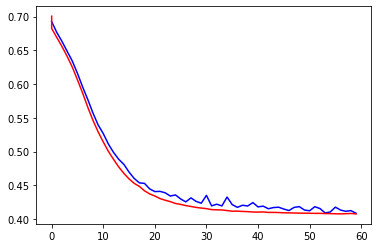

In [13]:
# we plot the loss evolution for the training dataset and the validation
plt.plot(model.history['train_e'], model.history['loss']['train'], 'b')
plt.plot(model.history['val_e'], model.history['loss']['val'], 'r')

In [ ]:
# we can observe that the two curves are close

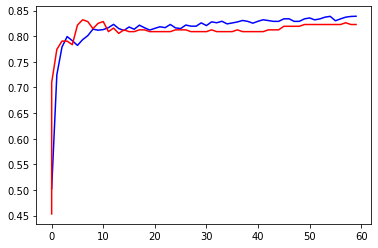

In [14]:
plt.plot(model.history['train_e'], model.history['acc']['train'], 'b')
plt.plot(model.history['val_e'], model.history['acc']['val'], 'r')

In [15]:
# %load_ext tensorboard

In [16]:
# %tensorboard --logdir logs
# notebook.display(port=6006, height=1200)

In [17]:
# testing with 
trainer.test(model, dataset)
print(model.test_score['avg_loss'], model.test_score['avg_acc'])

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
tensor(0.4076) tensor(0.8229)


## 5) K-fold validation

In [19]:
# control the model with cross validation
# we save the score of each run in kfold_res
kfold_res = []
kf = KFold(n_splits=5)
for train_idx, test_idx in kf.split(df_full):
    df_train = df_full.iloc[train_idx]
    df_test = df_full.iloc[test_idx]
    dataset = Titanic_Data(df_train, df_test, df_test)
    model = Mod_0()

    tb_logger = pl_loggers.TensorBoardLogger("logs/")
    trainer = Trainer(max_epochs=60, auto_lr_find=True, logger=tb_logger)
    trainer.fit(model, dataset)
    trainer.test(model, dataset)
    kfold_res += [(model.test_score['avg_loss'].numpy(), 
                   model.test_score['avg_acc'].numpy())]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


### Stats

In [25]:
losses, accs = zip(*kfold_res)
stats = [['metric', 'min', 'mean', 'max']]
for d, name in zip([losses, accs], ['loss', 'acc']):
  rm = [name]
  for f in [np.min, np.mean, np.max]:
    rm += [f(d)]
  stats +=[rm]
print(tabulate.tabulate(stats, headers="firstrow"))

metric         min      mean       max
--------  --------  --------  --------
loss      0.342331  0.415927  0.453511
acc       0.796296  0.829593  0.877315


In [ ]:
# accuracy for each model is close to 82%

## Training a final model with all data 

In [27]:
# final model : train with the full dataset !

dataset = Titanic_Data(df_full, df_full, df_full)
final_model = Mod_0()

tb_logger = pl_loggers.TensorBoardLogger("logs/")
trainer = Trainer(max_epochs=60, auto_lr_find=True, logger=tb_logger)
trainer.fit(final_model, dataset)
trainer.test(final_model, dataset)
print("Results of the final training => loss:{} acc:{}".format(model.test_score['avg_loss'].numpy(), 
      model.test_score['avg_acc'].numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type     | Params
------------------------------------
0 | l1     | Linear   | 220   
1 | drop1  | Dropout  | 0     
2 | l3     | Linear   | 21    
3 | loss   | BCELoss  | 0     
4 | metric | Accuracy | 0     
------------------------------------
241       Trainable params
0         Non-trainable params
241       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Results of the final training => loss:0.3423309028148651 acc:0.8773148059844971


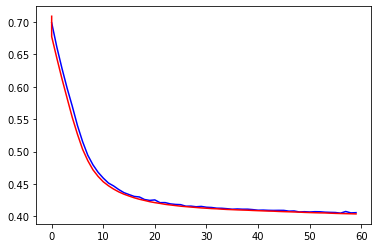

In [28]:
# we plot the loss curvephilippe#1108
plt.plot(final_model.history['train_e'], final_model.history['loss']['train'], 'b')
plt.plot(final_model.history['val_e'], final_model.history['loss']['val'], 'r')